In [1]:
import numpy as np
import pandas as pd
import os
import glob
import itertools
import scanpy as sc
import natsort
import json

from scroutines import basicu

import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
from scroutines.config_plots import *

In [20]:
class Bigtensor():
    def __init__(self, bigtensor, meta):
        
        self.palette = {
            'NR': 'C1', 
            'DR': 'k',
            'DL': 'C2', 
        }

        self.anno_marker_dict = {
            'NR': 'o',
            'DR': '^',
            'DL': 'x',
        }
        
        self.anno_alpha_dict = {
            'NR': 1,
            'DR': 0.5,
            'DL': 0.5,
        }
        
        self.anno_markersize_dict = {
            'NR': 3,
            'DR': 10,
            'DL': 10,
        }
        
        self.bigtensor = bigtensor
        self.nf, self.nr, self.nc, self.ng = meta['size']
        self.conds = np.array(meta['dim0'])
        self.reps  = np.array(meta['dim1'])
        self.types = np.array(meta['dim2'])
        self.genes = np.array(meta['dim3'])

        self.conds_time = np.array([int(cond[1:-2]) for cond in self.conds])
        self.conds_anno = np.array([cond[-2:] for cond in self.conds])
        self.conds_color = pd.Series(self.palette).loc[self.conds_anno].values 
        
        return
    
    def plot_one(self, ax, selected_type, selected_gene, annotate=True):
        """
        """
        type_idx = basicu.get_index_from_array(self.types, [selected_type])[0]
        gene_idx = basicu.get_index_from_array(self.genes, [selected_gene])[0]
        
        assert np.all(type_idx != -1)
        assert np.all(gene_idx != -1)

        vals = self.bigtensor[:,:,type_idx, gene_idx] # cond by rep
        vals_mean = np.nanmean(vals, axis=1)


        ax.set_title(f'{selected_gene} in {selected_type}')
        for anno in ['NR', 'DR', 'DL']:
            marker = self.anno_marker_dict[anno]
            sel = self.conds_anno == anno
            if sel.sum() > 0:
                
                if anno == 'NR':
                    ax.set_xticks(self.conds_time[sel])
                    ax.plot(self.conds_time[sel], vals_mean[sel], '-k')

                ax.scatter(np.repeat(self.conds_time[sel], self.nr), vals[sel].reshape(-1,), 
                           color='k',
                           facecolors='none',
                           marker=marker,
                           label=anno,
                          )

        sns.despine(ax=ax)
        ax.grid(axis='x')

        if annotate:
            handles, labels = ax.get_legend_handles_labels()
            unique_labels = dict(zip(labels, handles))
            ax.legend(unique_labels.values(), unique_labels.keys(), fontsize=12) # , bbox_to_anchor=(1,1))

            ax.set_xlabel('Postnatal day (P)')
            ax.set_ylabel('log2(CPM+1)')
        
    def plot_one_simple(self, ax, selected_type, selected_gene, annotate=True, color='k'):
        """
        """
        type_idx = basicu.get_index_from_array(self.types, [selected_type])[0]
        gene_idx = basicu.get_index_from_array(self.genes, [selected_gene])[0]

        assert np.all(type_idx != -1)
        assert np.all(gene_idx != -1)
        
        vals = self.bigtensor[:,:,type_idx, gene_idx] # cond by rep
        vals_mean = np.nanmean(vals, axis=1)


        ax.set_title(f'{selected_gene} in {selected_type}')
        for anno in ['NR', 'DR', 'DL']:
            marker = self.anno_marker_dict[anno]
            sel = self.conds_anno == anno
            if sel.sum() > 0:
                
                if anno == 'NR':
                    ax.plot(self.conds_time[sel], vals_mean[sel], '-', color=color)
                    
                ax.scatter(np.repeat(self.conds_time[sel], self.nr), vals[sel].reshape(-1,), 
                           color=color,
                           facecolors='none',
                           marker=marker,
                           label=anno,
                          )

        sns.despine(ax=ax)

        if annotate:
            handles, labels = ax.get_legend_handles_labels()
            unique_labels = dict(zip(labels, handles))
            ax.legend(unique_labels.values(), unique_labels.keys(), fontsize=12) # , bbox_to_anchor=(1,1))

            ax.set_xlabel('Postnatal day (P)')
            ax.set_ylabel('log2(CPM+1)')
        
    def plot_one_simple_v2(self, ax, selected_type, selected_gene, annotate=True, color='k', nr_only=False):
        """
        """
        type_idx = basicu.get_index_from_array(self.types, [selected_type])[0]
        gene_idx = basicu.get_index_from_array(self.genes, [selected_gene])[0]

        assert np.all(type_idx != -1)
        assert np.all(gene_idx != -1)
        
        vals = self.bigtensor[:,:,type_idx, gene_idx] # cond by rep
        vals_mean = np.nanmean(vals, axis=1)


        ax.set_title(f'{selected_gene} in {selected_type}')
        for anno in ['NR', 'DR', 'DL']:
            if nr_only and anno != 'NR':
                continue
                
            marker = self.anno_marker_dict[anno]
            alpha = self.anno_alpha_dict[anno]
            s = self.anno_markersize_dict[anno]
            
            sel = self.conds_anno == anno
            if sel.sum() > 0:
                
                if anno in ['NR', 'DR']:
                    ax.plot(self.conds_time[sel], vals_mean[sel], '-', color=color, alpha=alpha)
                    facecolor=color
                if anno == 'NR':
                    label = selected_type
                else:
                    label = None

                ax.scatter(np.repeat(self.conds_time[sel], self.nr), vals[sel].reshape(-1,), 
                           color=color,
                           s=s,
                           marker=marker,
                           facecolors=facecolor,
                           label=label, # selected_type, #+'_'+anno,
                           linewidth=1,
                          )

        sns.despine(ax=ax)

        if annotate:
            handles, labels = ax.get_legend_handles_labels()
            unique_labels = dict(zip(labels, handles))
            ax.legend(unique_labels.values(), unique_labels.keys(), fontsize=12) # , bbox_to_anchor=(1,1))

            ax.set_xlabel('Postnatal day (P)')
            ax.set_ylabel('log2(CPM+1)')
        

In [24]:
f_data = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/res/bigtensor_l23type_10bin.npy' 
f_meta = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/res/bigtensor_l23type_10bin.json' 

bigtensor = np.load(f_data)
with open(f_meta, 'r') as fp:
    meta = json.load(fp)

bo0 = Bigtensor(bigtensor, meta)
print(bigtensor.shape)

(9, 2, 10, 16572)


In [25]:
f_data = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/v1_multiome/res/bigtensor_l23type_10bin.npy' 
f_meta = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/v1_multiome/res/bigtensor_l23type_10bin.json' 

bigtensor = np.load(f_data)
with open(f_meta, 'r') as fp:
    meta = json.load(fp)

bo1 = Bigtensor(bigtensor, meta)
print(bigtensor.shape)

(11, 3, 10, 16572)


In [26]:
f_data = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/res/bigtensor_subclass_v2.npy' 
f_meta = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/res/bigtensor_subclass_v2.json' 

bigtensor = np.load(f_data)
with open(f_meta, 'r') as fp:
    meta = json.load(fp)

bbo0 = Bigtensor(bigtensor, meta)
print(bigtensor.shape)

(9, 2, 20, 16572)


In [27]:
f_data = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/v1_multiome/res/bigtensor_subclass_v2.npy' 
f_meta = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/v1_multiome/res/bigtensor_subclass_v2.json' 

bigtensor = np.load(f_data)
with open(f_meta, 'r') as fp:
    meta = json.load(fp)

bbo1 = Bigtensor(bigtensor, meta)
print(bigtensor.shape)

(11, 3, 18, 16572)


# plot

In [28]:
def plot_combined(bo0, bo1, gene, types):
    xticks = [6,10,14,17,21,28,38]
    n = len(types)
    
    fig, axs = plt.subplots(1,n,figsize=(n*4,1*4), sharex=True, sharey=True)
    for ax, thistype in zip(axs, types):
        bo0.plot_one_simple(ax, thistype, gene, color='k')
        bo1.plot_one_simple(ax, thistype, gene, annotate=False, color='C1')
        ax.set_xticks(xticks)
        ax.grid(axis='x')

    plt.show()
    
def plot_combined_v2(bo0, bo1, gene, types, colors, legend=False, ylim=None, nr_only=False):
    n = 2
    # n = len(types)
    
    fig, axs = plt.subplots(1,n,figsize=(n*4,1*4), sharey=True)
    for ax, bo in zip(axs, [bo0, bo1]): 
        for i, thistype in enumerate(types):
            annotate = False
            bo.plot_one_simple_v2(ax, thistype, gene, annotate=annotate, color=colors[i], nr_only=nr_only)
        ax.grid(axis='x')
    axs[0].set_xlabel('Postnatal day (P)')
    axs[0].set_ylabel('log2(CPM+1)')
    axs[0].set_title(f'{gene} in Cheng22')
    xticks = [6,10,14,17,21,28,38]
    axs[0].set_xticks(xticks)
    
    axs[1].set_title(f'{gene} in multiome')
    xticks = [6,10,14,17,21]
    axs[1].set_xticks(xticks)
    
    if legend:
        axs[1].legend(bbox_to_anchor=(1,1))
        
    if ylim is not None:
        axs[1].set_ylim(ylim)
    
    plt.show()

In [29]:
types_l23 = ['0', '2', '5', '7', '9']#['A', 'B', 'C']
colors_l23 = ['C0', 'red', 'C1', 'purple', 'C2']

types_inh = ['Pvalb', 'Sst', 'Vip', 'Lamp5']
colors_inh = sns.color_palette('Set2', 4)
# colors_inh = ['C3', 'C4', 'C5', 'C6']
colors_inh

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)]

In [30]:
from matplotlib.colors import LinearSegmentedColormap

colors_a = [(0.0, 'black'), (1.0, 'C0')]      
colors_b = [(0.0, 'black'), (1.0, 'C1')]      
colors_c = [(0.0, 'black'), (1.0, 'C2')]      

# Create a custom colormap using LinearSegmentedColormap
cmap_a = LinearSegmentedColormap.from_list('cmap_a', colors_a)
cmap_b = LinearSegmentedColormap.from_list('cmap_b', colors_b)
cmap_c = LinearSegmentedColormap.from_list('cmap_c', colors_c)

colors_l23 = [
    np.array(cmap_a(1.0)),
    0.7*np.array(cmap_a(1.0))+0.3*np.array(cmap_b(1.0)),
    np.array(cmap_b(1.0)),
    0.7*np.array(cmap_b(1.0))+0.3*np.array(cmap_c(1.0)),
    np.array(cmap_c(1.0)),
]

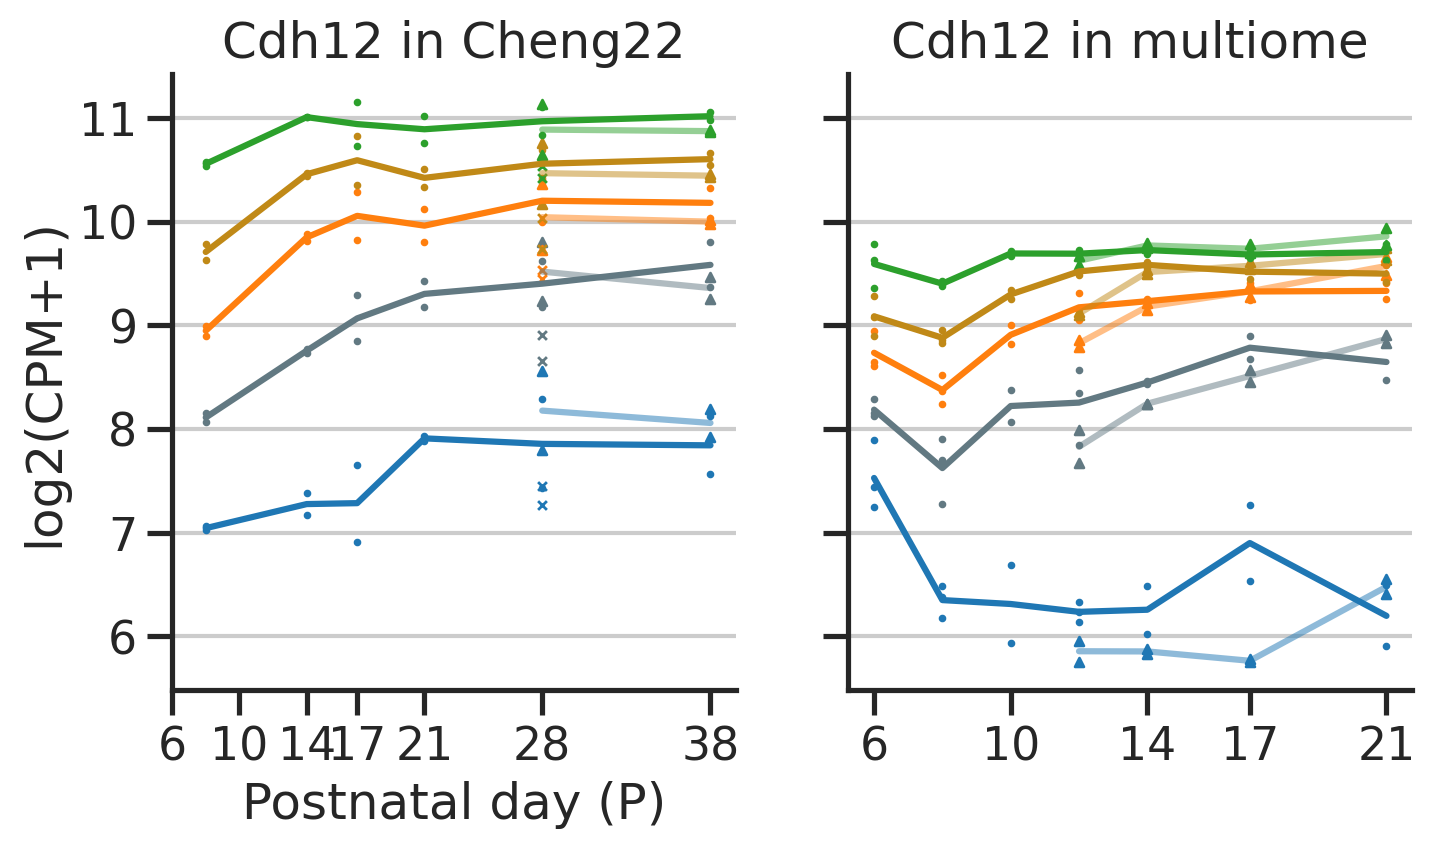

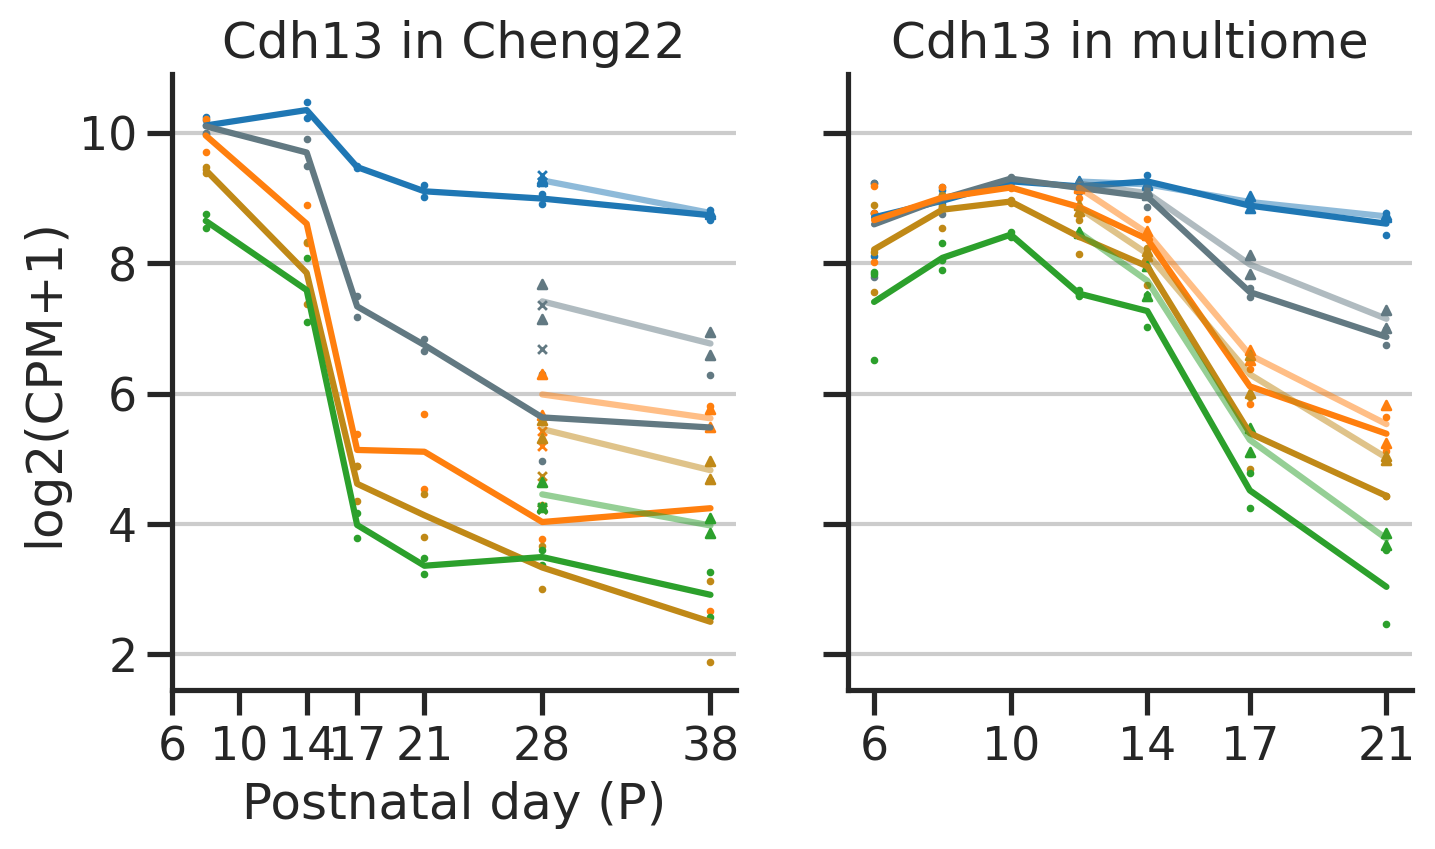

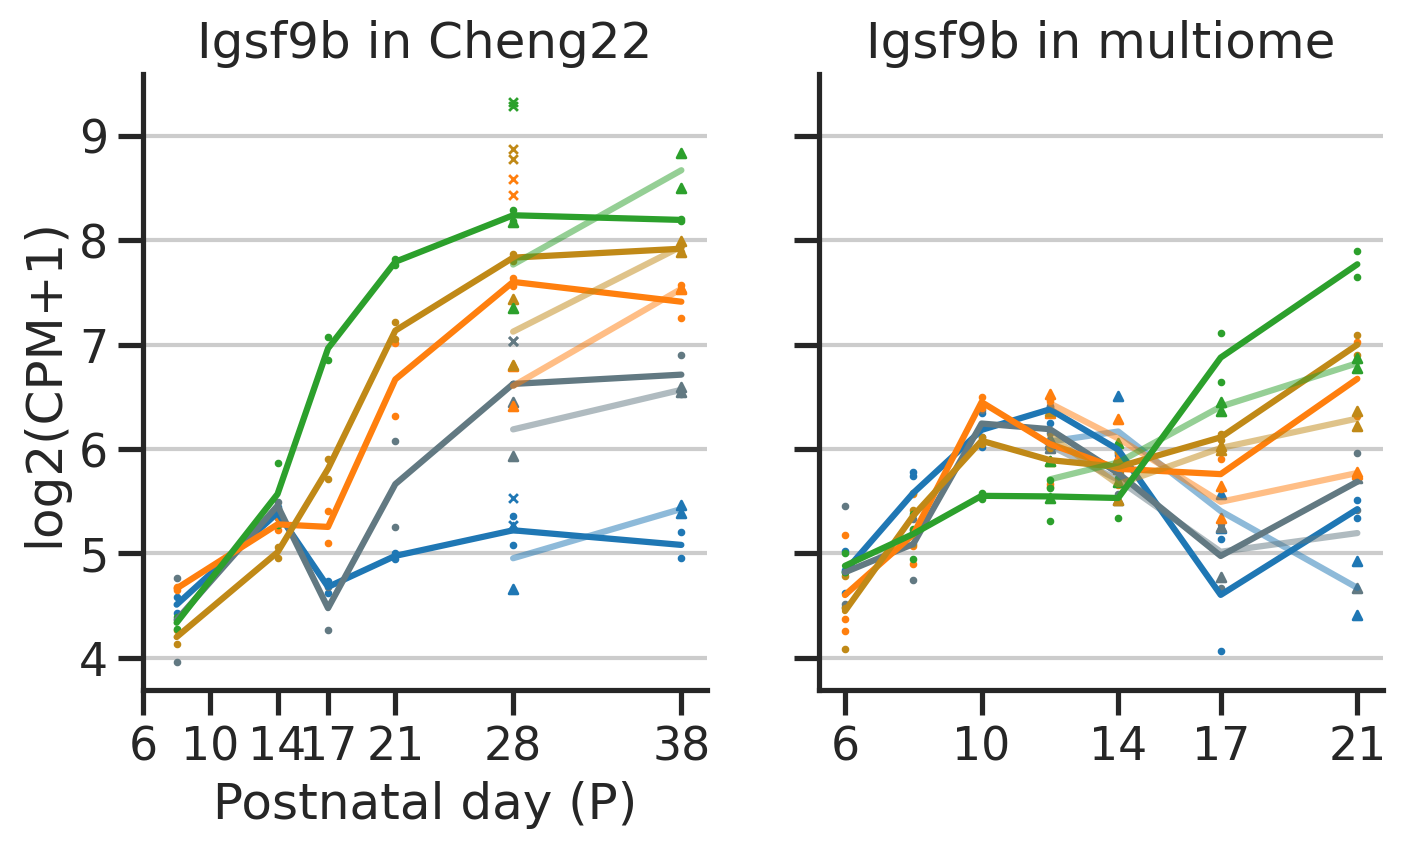

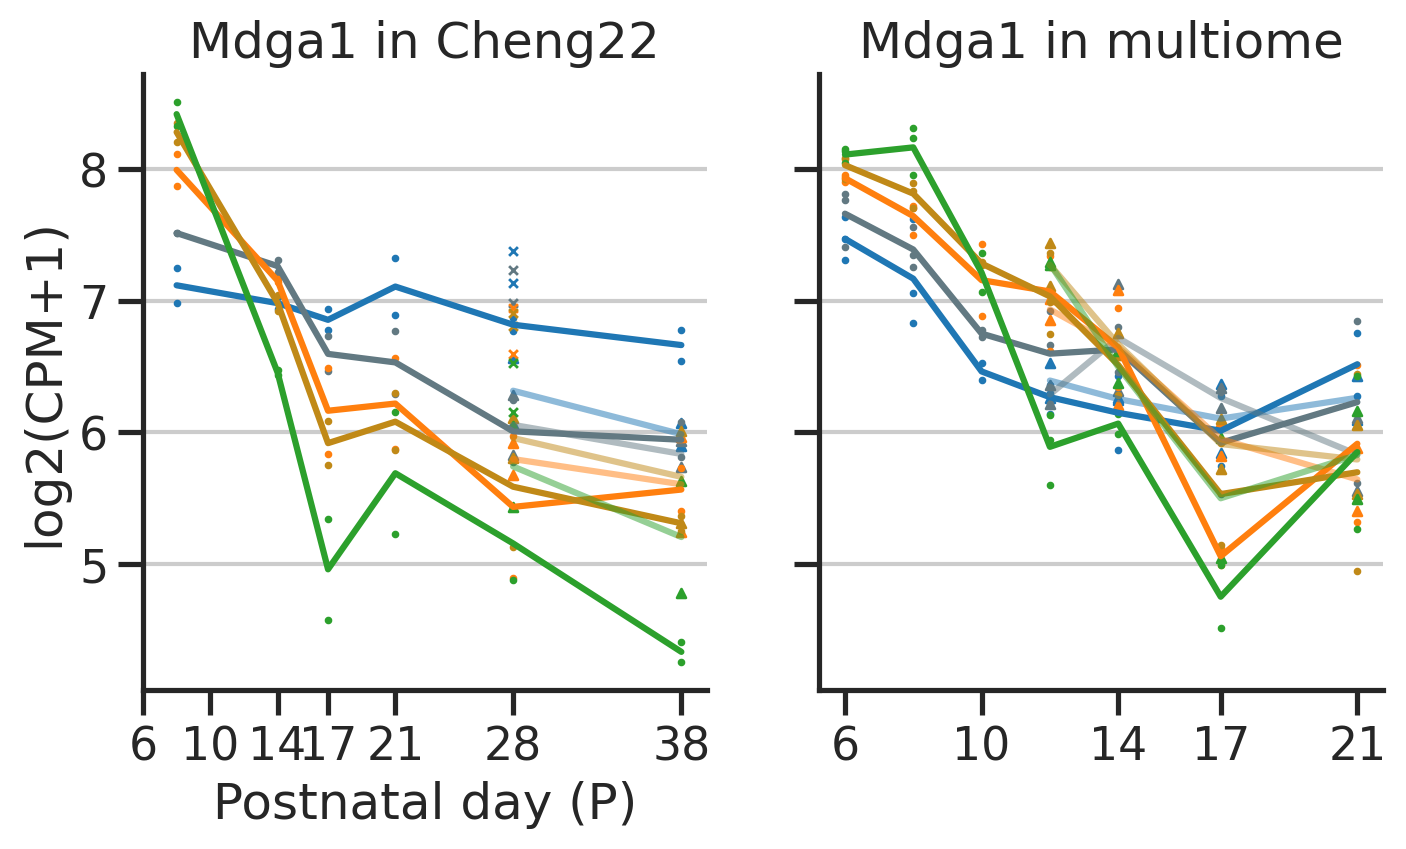

In [31]:
genes = ['Cdh12', 'Cdh13', 'Igsf9b', 'Mdga1',]
for gene in genes: 
    plot_combined_v2(bo0, bo1, gene, types_l23, colors_l23)

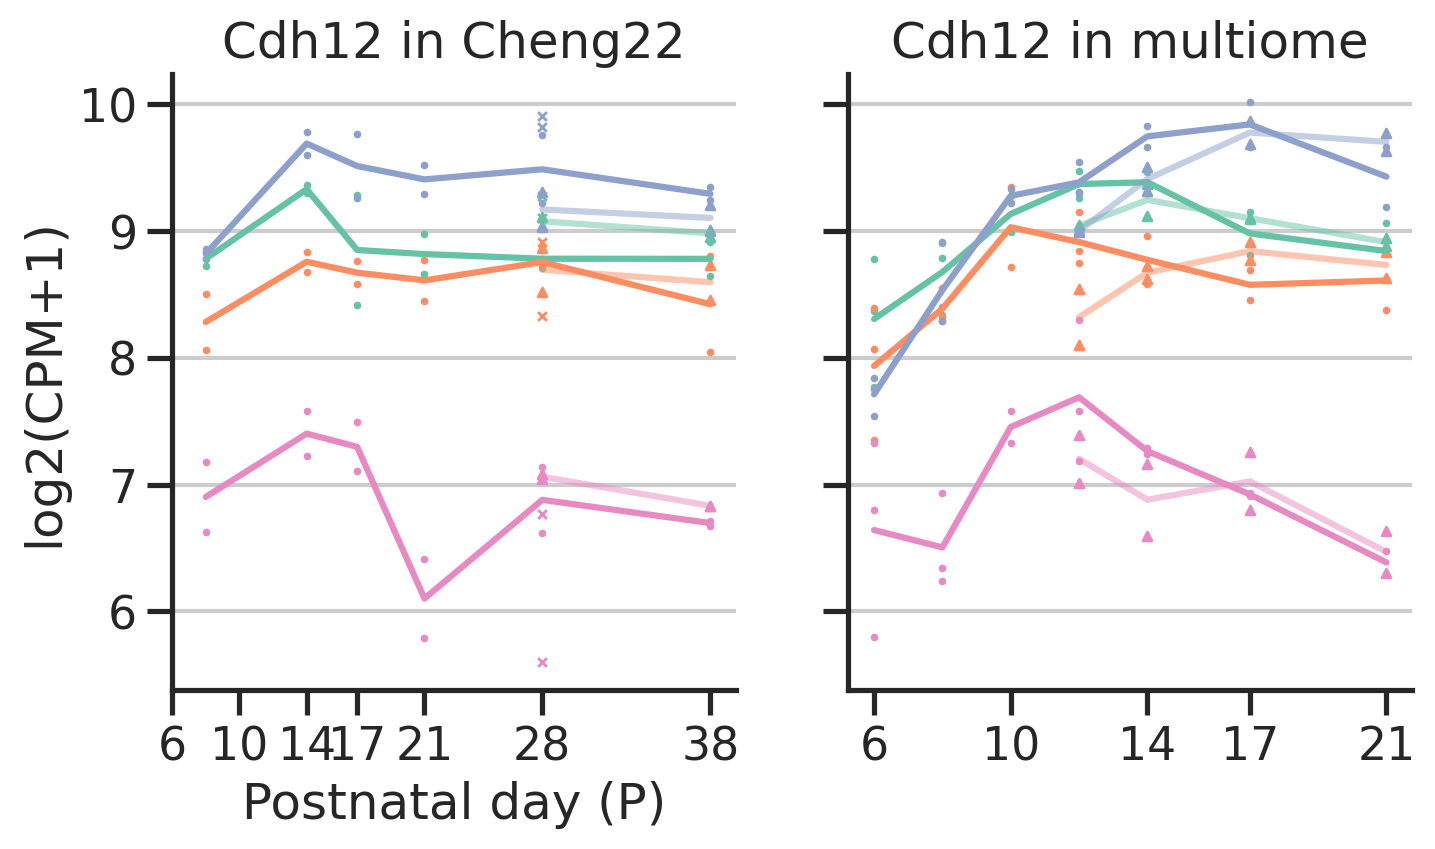

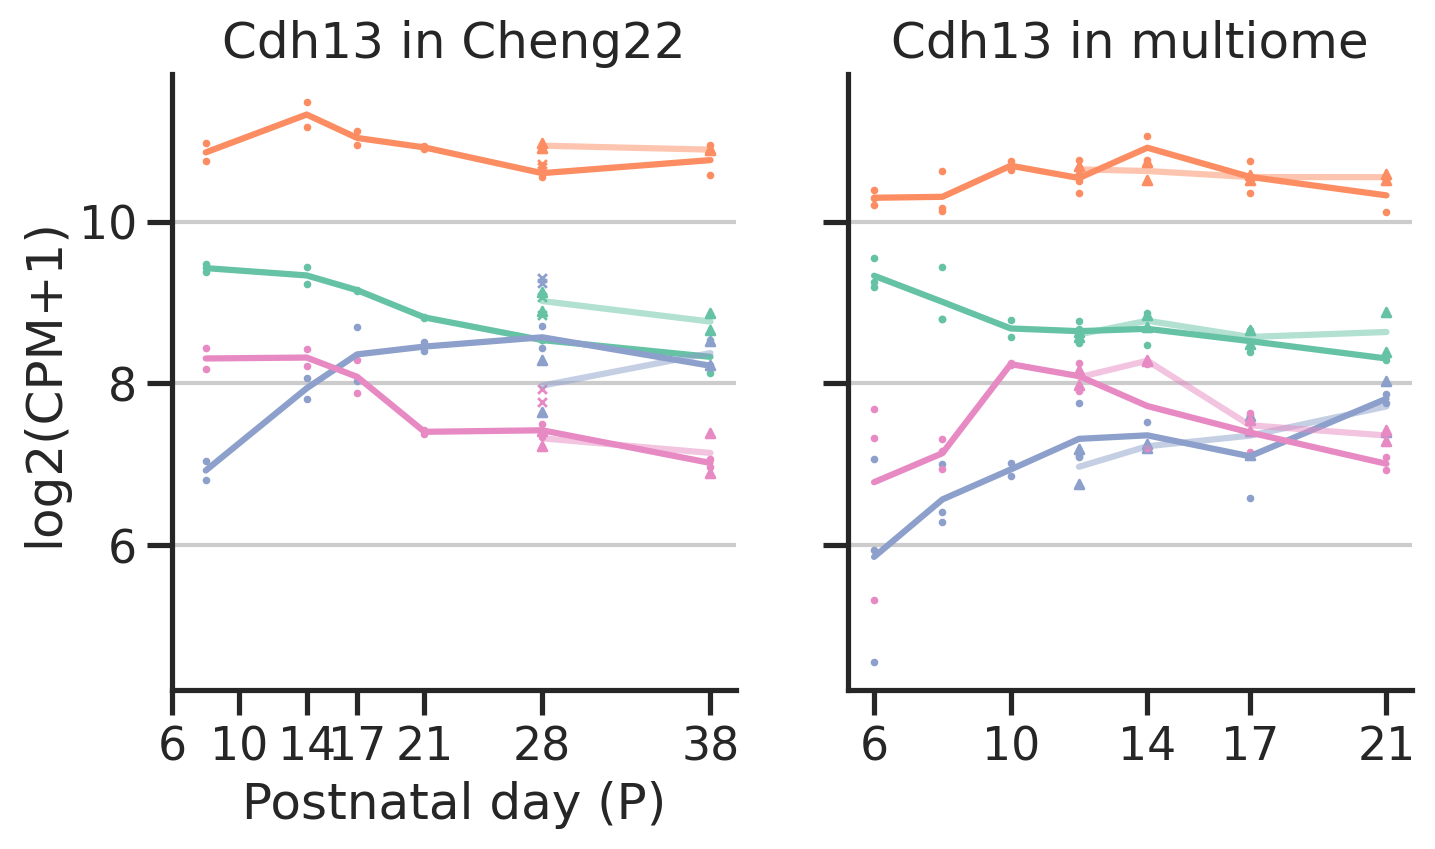

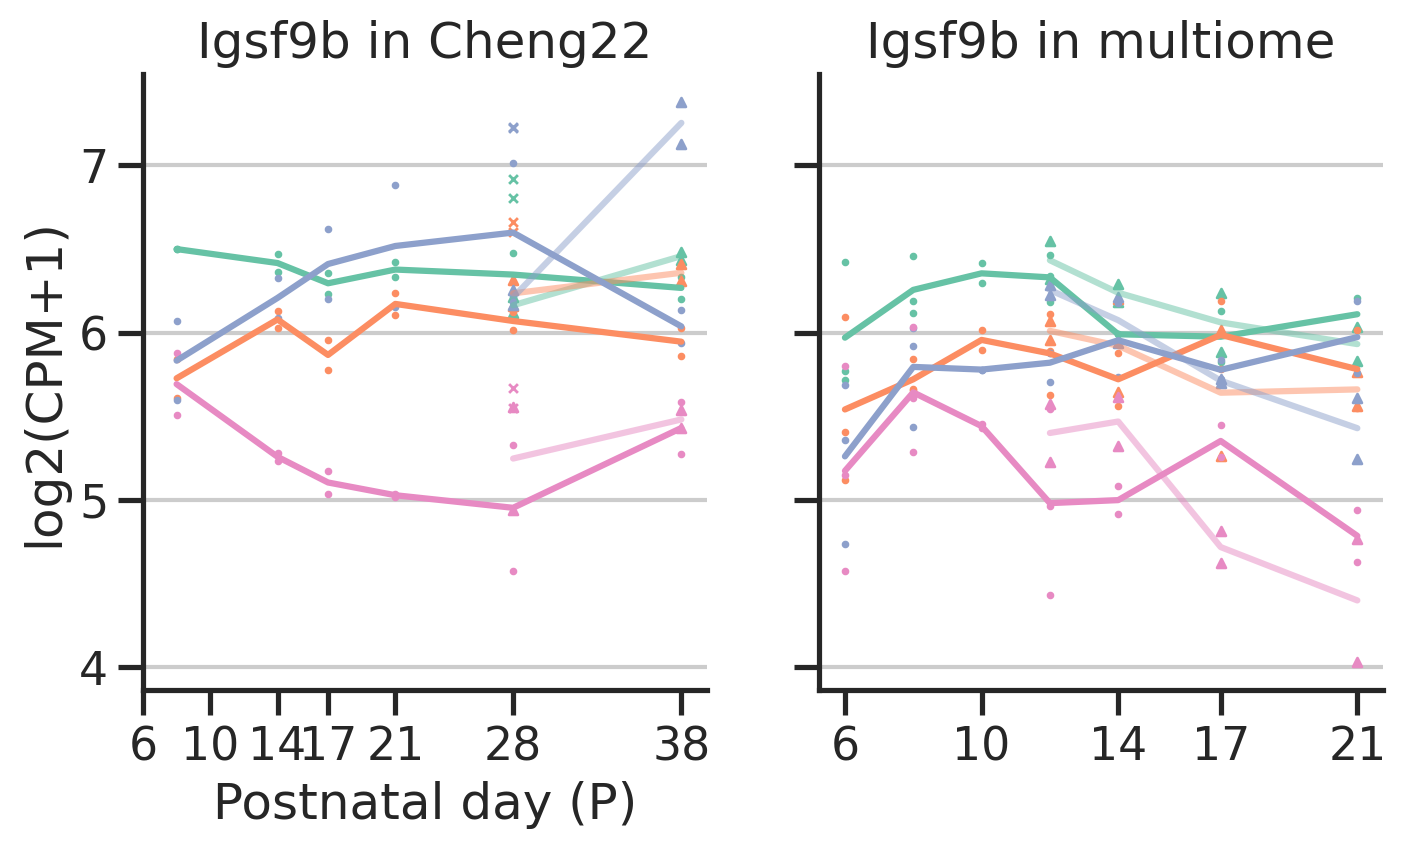

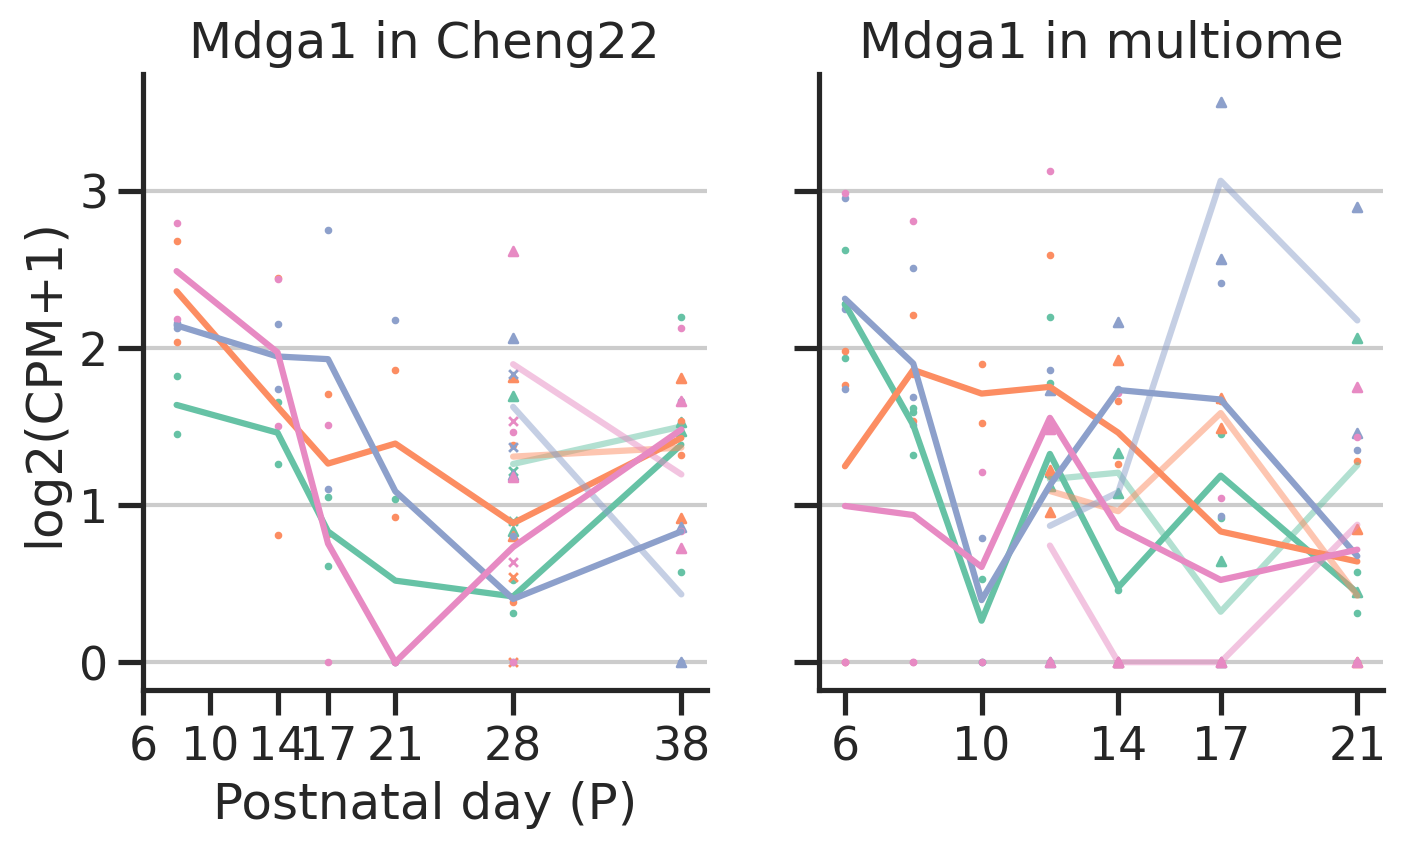

In [32]:
for gene in genes:
    plot_combined_v2(bbo0, bbo1, gene, types_inh, colors_inh) #, legend=True)

# GABAARs

In [33]:
selected_genes = [
    "Gabra1",
    "Gabra2",
    "Gabra3",
    "Gabra4",
    "Gabra5",
    # "Gabra6",
    
    # "Gabrb1",
    # "Gabrb2",
    # "Gabrb3",
    
    "Gabrg1",
    "Gabrg2",
    "Gabrg3",
    
    
    "Gabrd",    
    # "Gabre",    
    # "Gabrp",    
    # "Gabrq",    
    # "Gabrr1",
    # "Gabrr2",
    # "Gabrr3",
]
print(len(selected_genes), selected_genes)
selected_genes = np.intersect1d(selected_genes, bo0.genes)
print(len(selected_genes), selected_genes)

9 ['Gabra1', 'Gabra2', 'Gabra3', 'Gabra4', 'Gabra5', 'Gabrg1', 'Gabrg2', 'Gabrg3', 'Gabrd']
9 ['Gabra1' 'Gabra2' 'Gabra3' 'Gabra4' 'Gabra5' 'Gabrd' 'Gabrg1' 'Gabrg2'
 'Gabrg3']


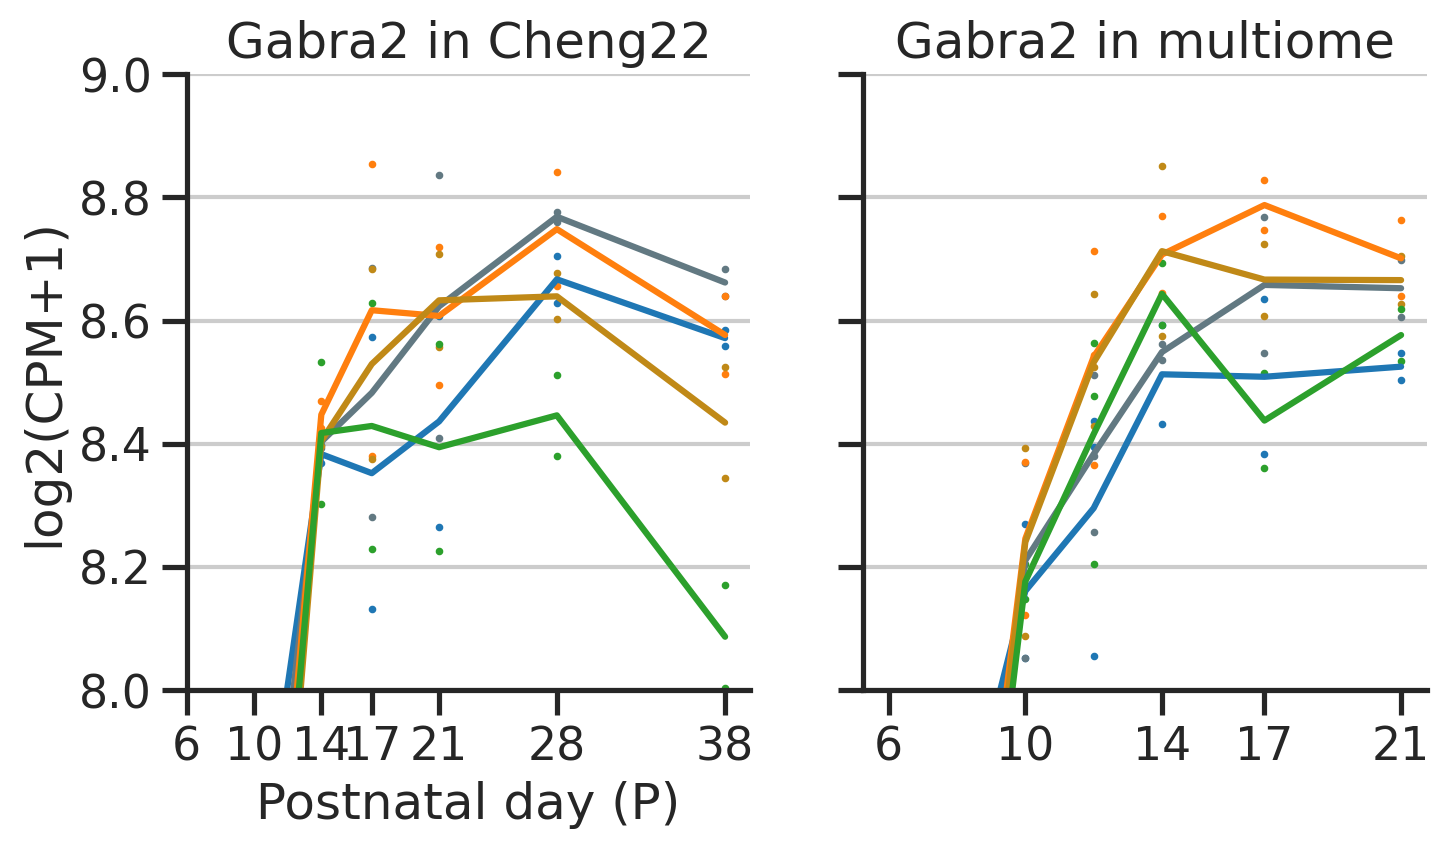

In [37]:
gene = 'Gabra2'
plot_combined_v2(bo0, bo1, gene, types_l23, colors_l23, ylim=[8,9], nr_only=True)

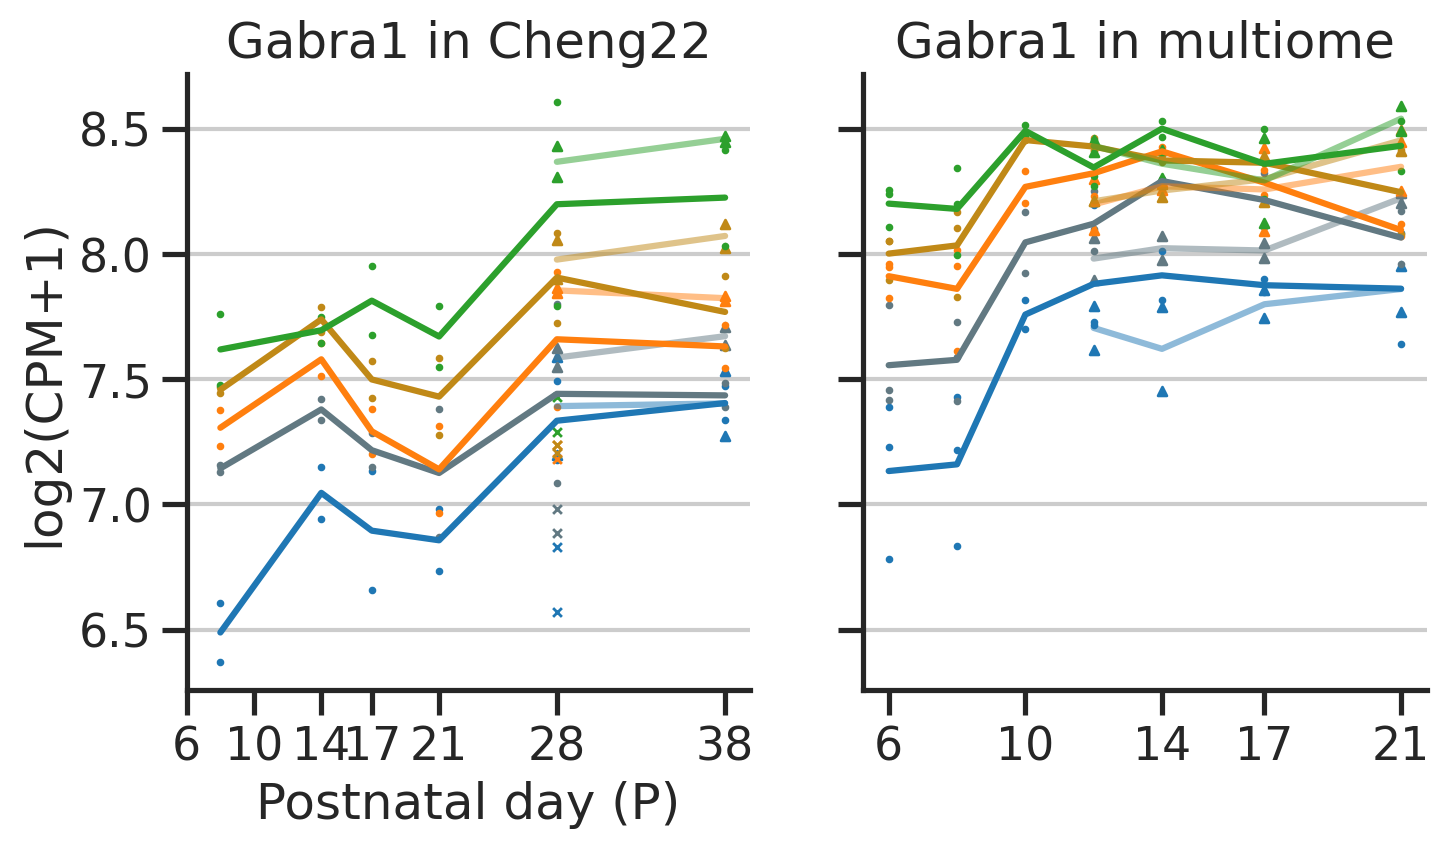

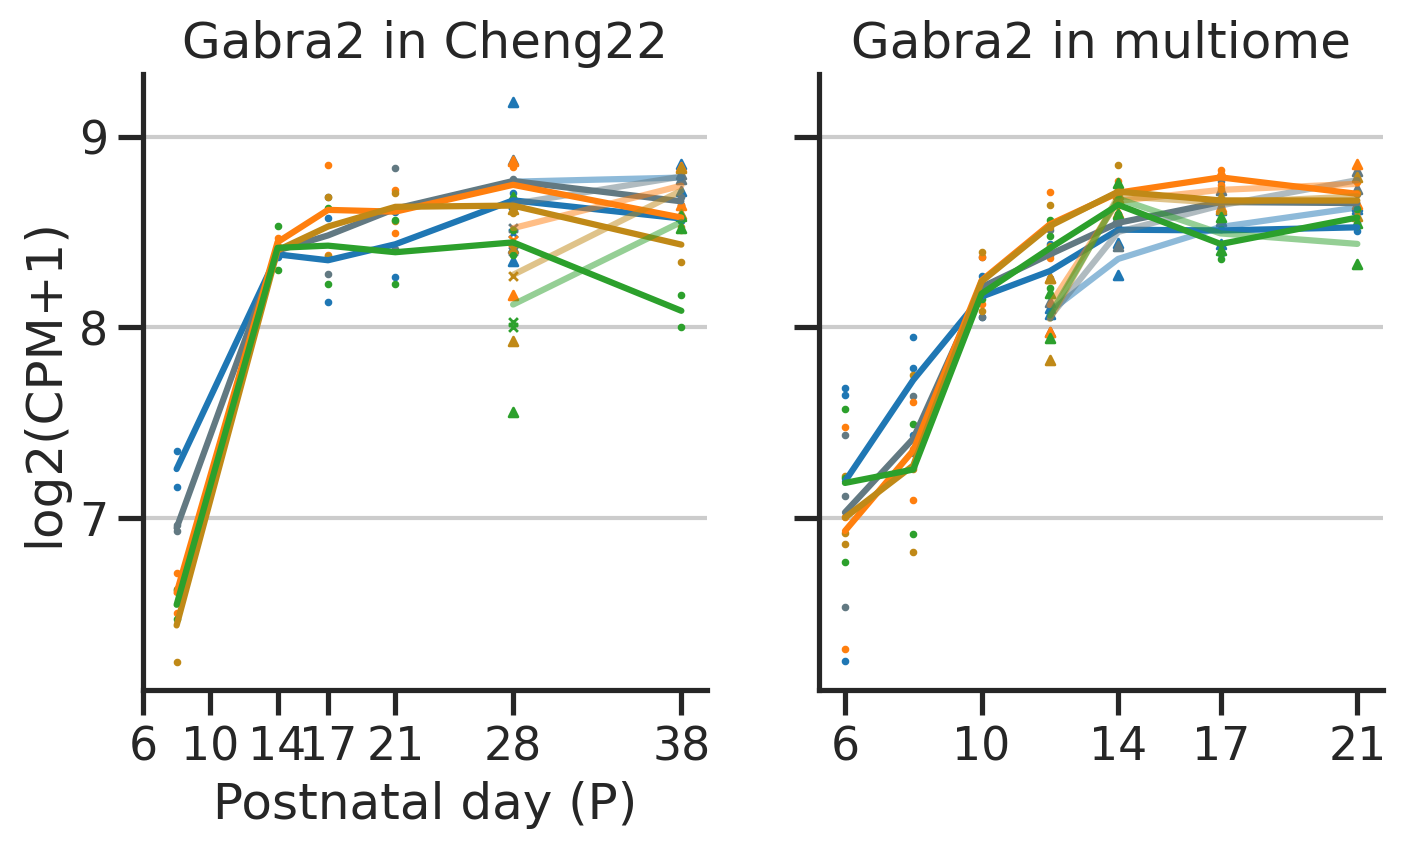

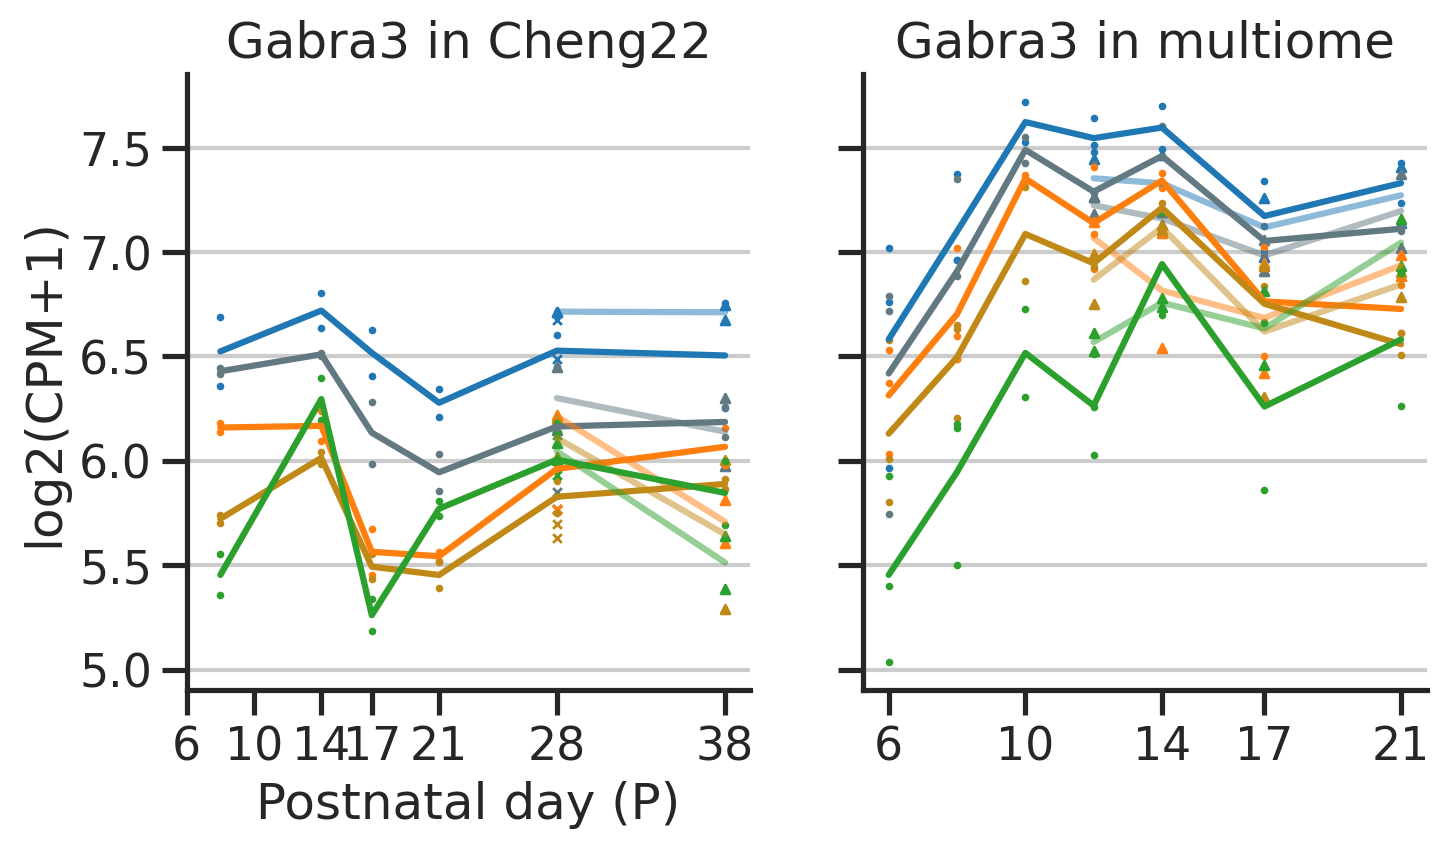

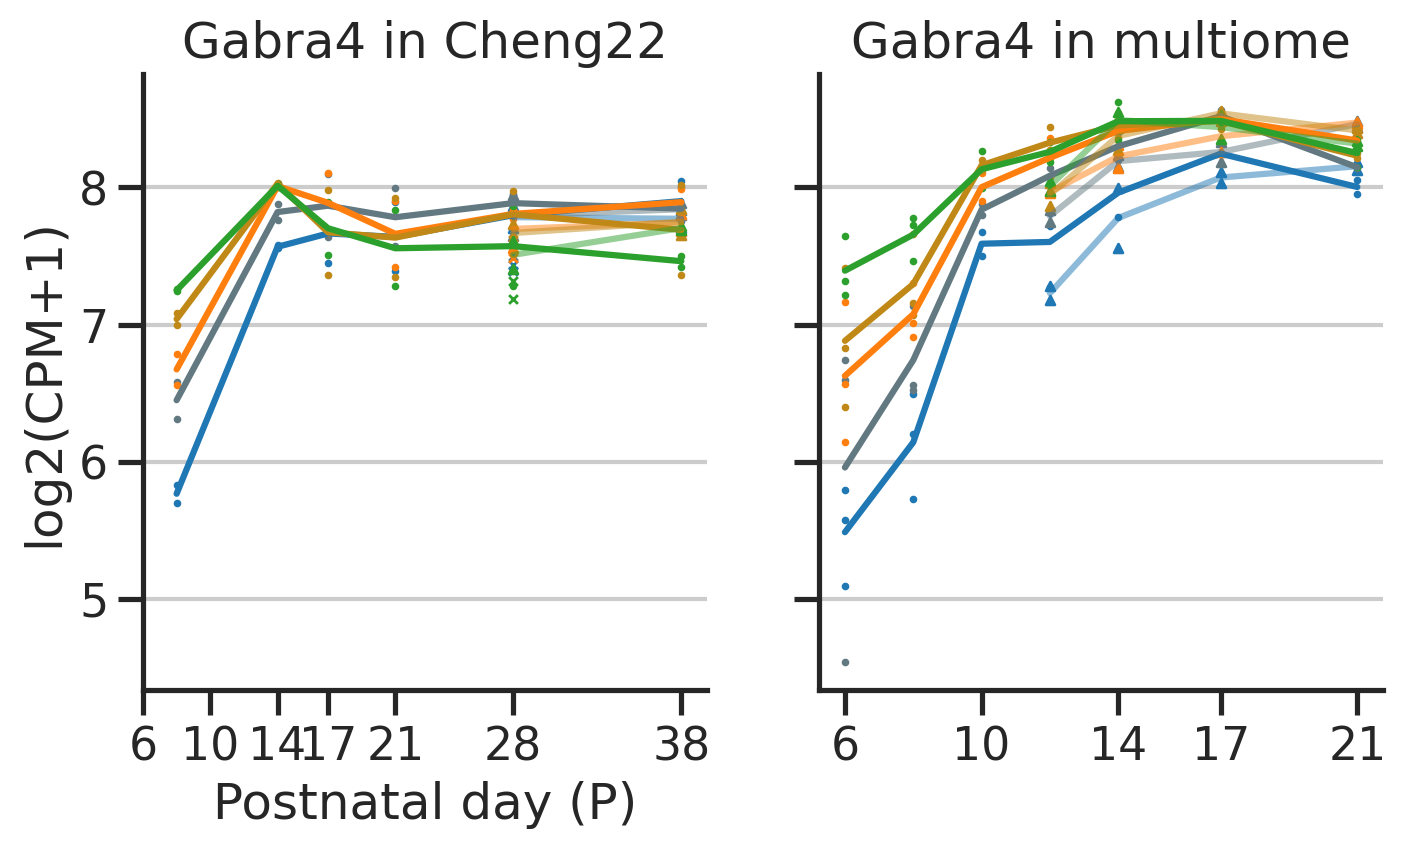

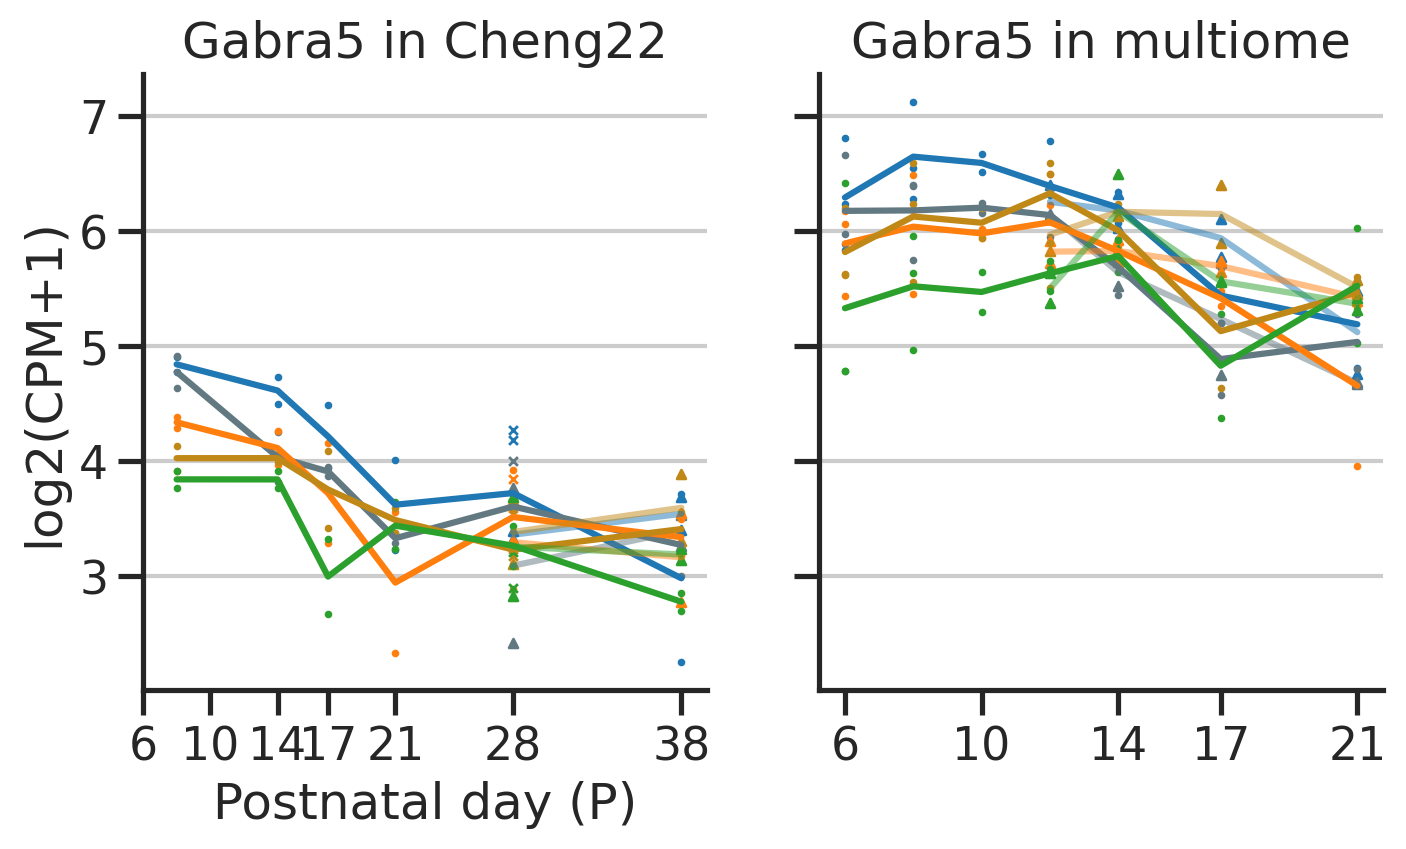

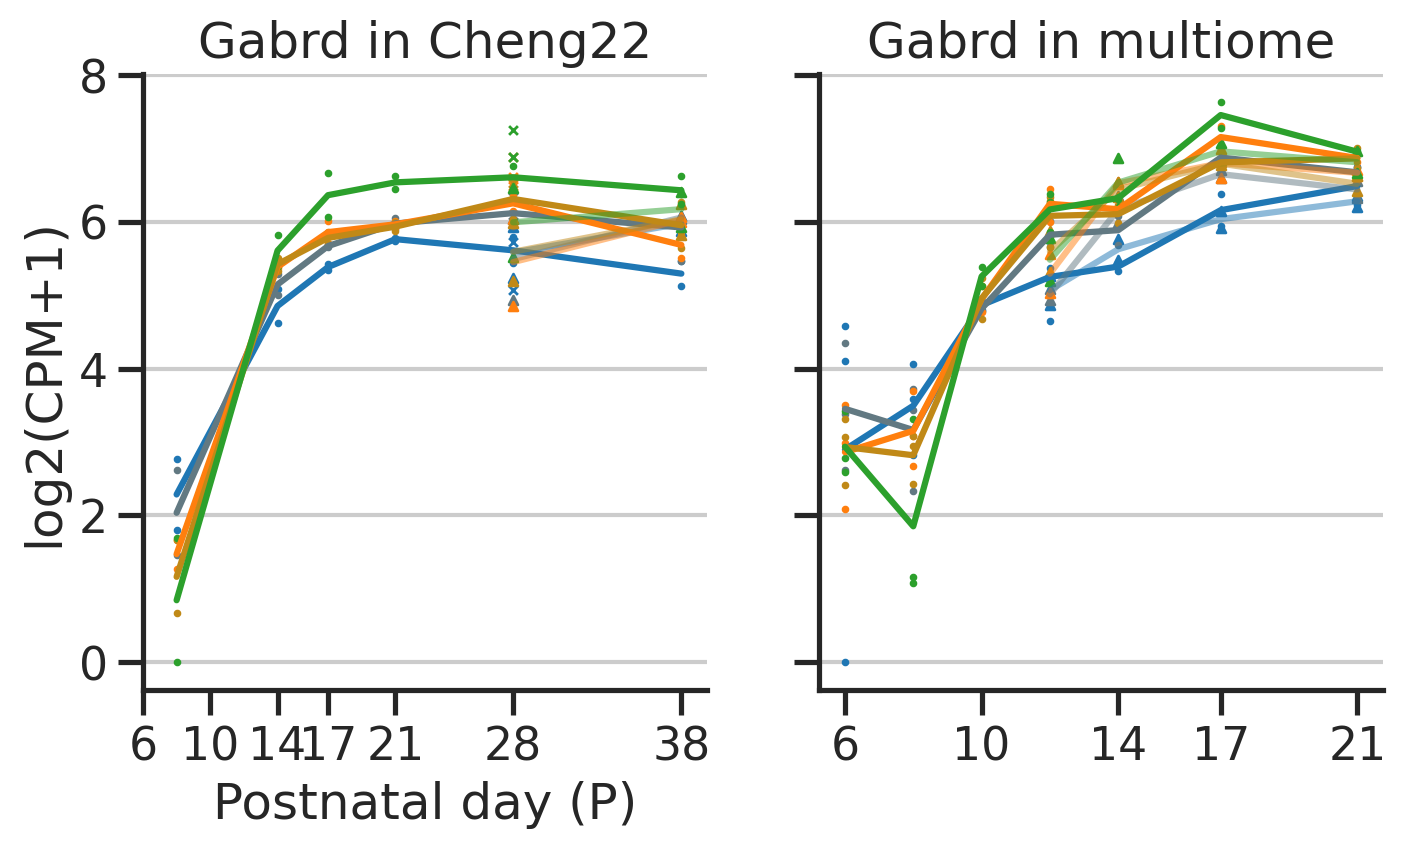

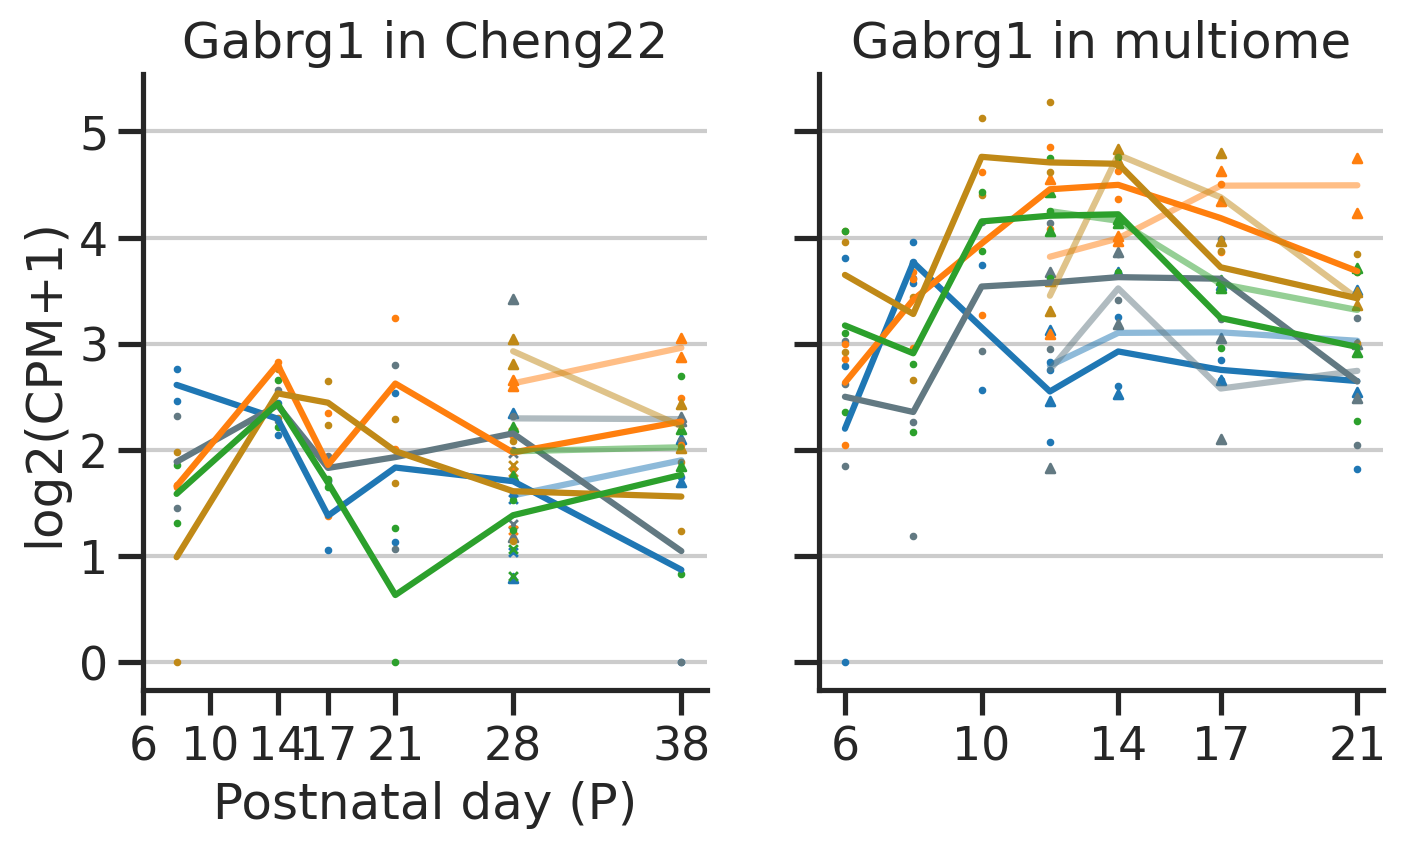

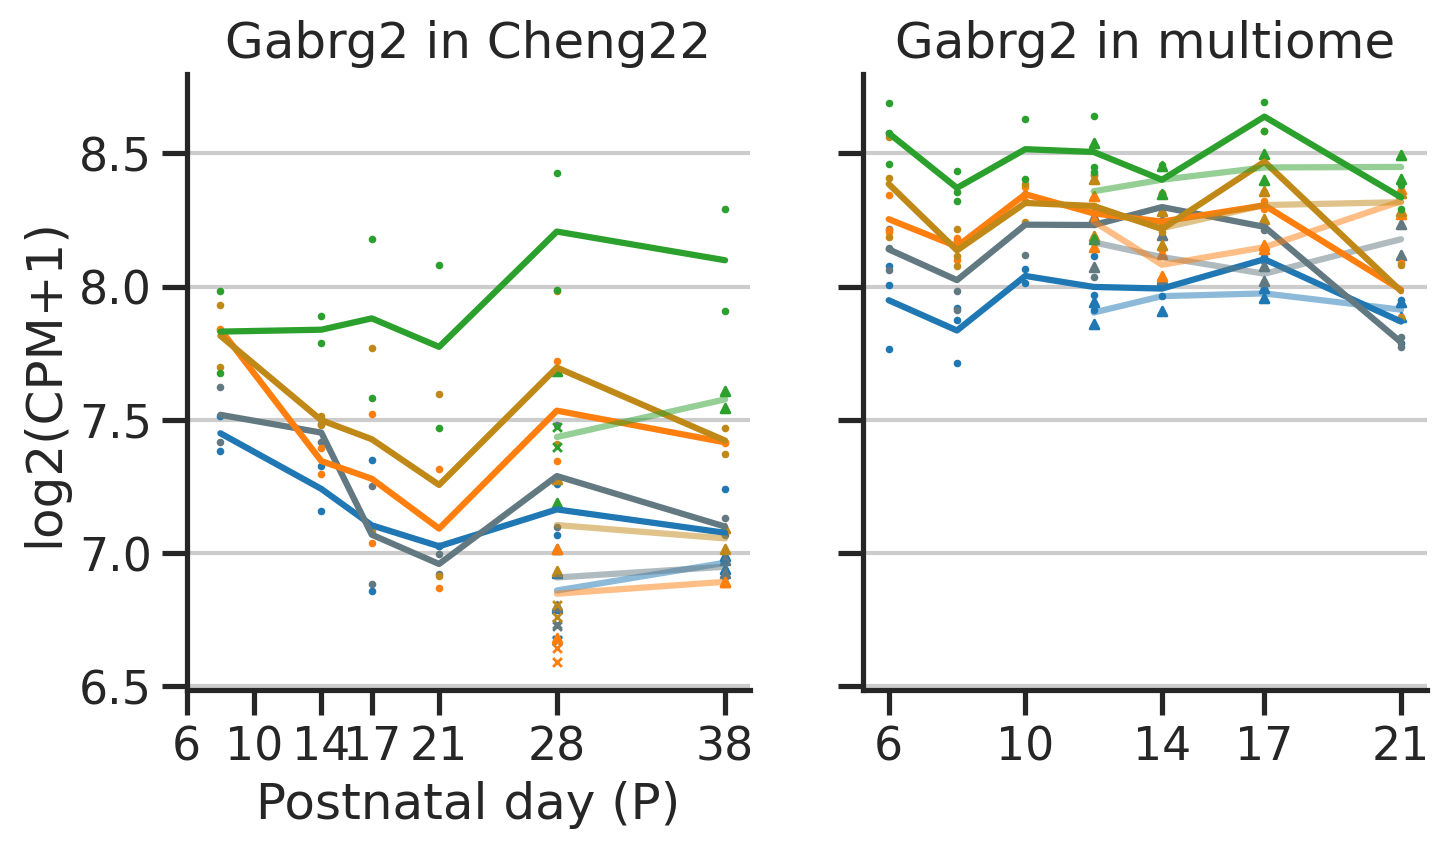

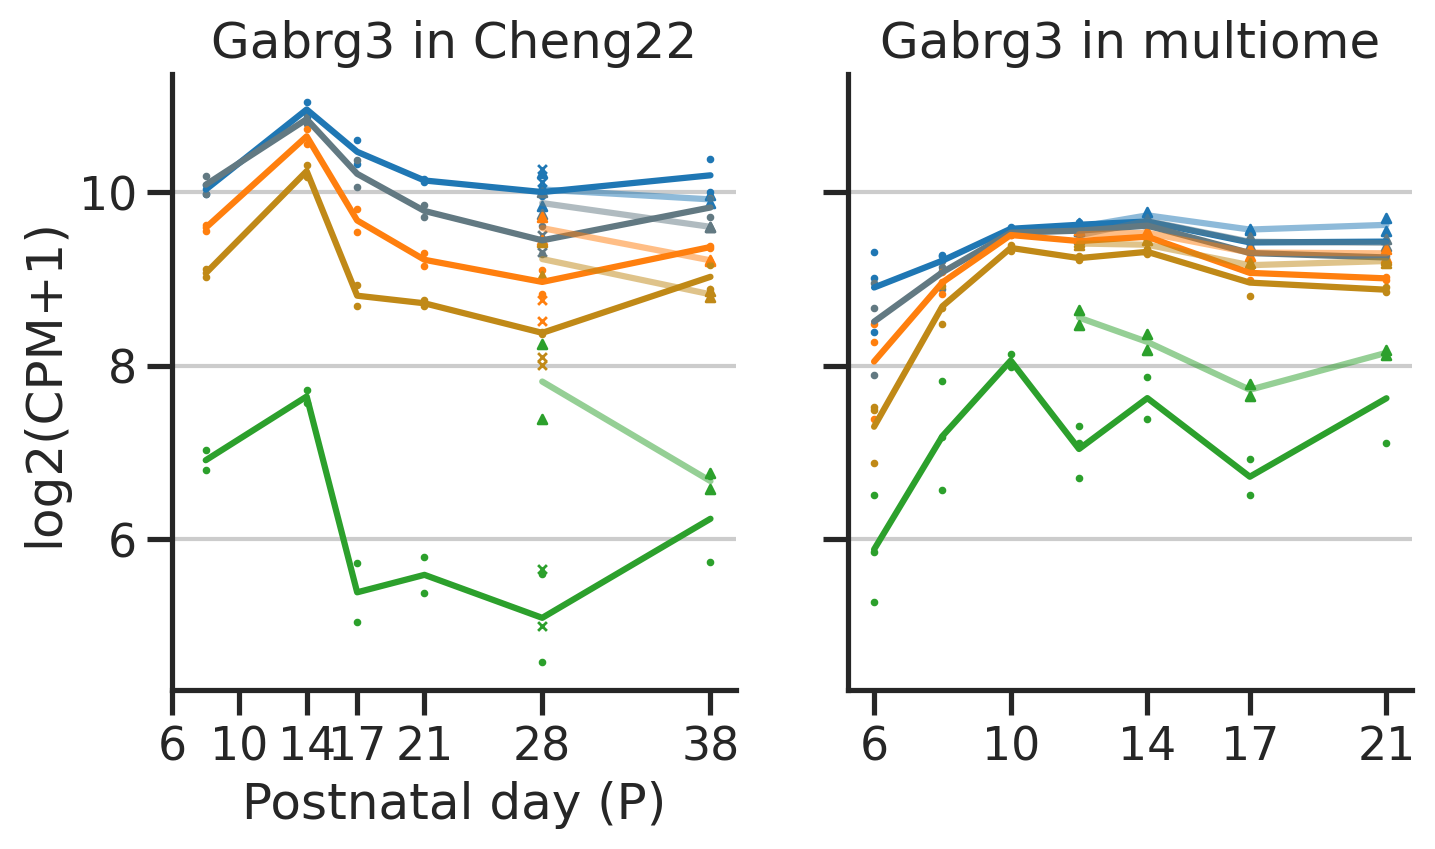

In [14]:
for gene in selected_genes:
    plot_combined_v2(bo0, bo1, gene, types_l23, colors_l23)